## Checking Bolton Approximation for $\sigma_{LCL}$
We want to approximate the $\sigma_{LCL} = p_{LCL}/p_s$ level in terms of just pseudo relative humidity, $r_s = q_s / q^*(T_s, p_s)$. Here, we evaluate the simple approximation derived from Equation 22 of Bolton 1980:

$$\frac{p_{LCL}}{p_s} \approx r_s^{\nu}$$

where $\nu = \frac{c_p}{2840 R} \frac{(T_s - 55)^2}{T_s}$ and $T_s$ is surface temperature.

The dependence on surface temperature is weak, so we just providing a reasonable guess, so LCL variation is then just in terms of relative humidity.

The error is small, with the major error for dry days, maybe as expected.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from isca_tools.convection.base import lcl_metpy, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize
from isca_tools.utils.constants import lapse_dry, R, g
from isca_tools.utils.moist_physics import sphum_sat

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
temp_surf = np.linspace(270, 330, 61)
rh_surf = np.linspace(1, 100, 100)/100
p_surf = 1000 * 100
temp_surf_bolton_use = np.median(temp_surf)

In [4]:
temp_use, rh_use = np.meshgrid(temp_surf, rh_surf, indexing='xy')
sigma_metpy = lcl_metpy(temp_use, rh_use * sphum_sat(temp_use, p_surf), p_surf)[0]/p_surf
sigma_bolton = lcl_sigma_bolton_simple(rh_use, temp_surf_bolton_use)

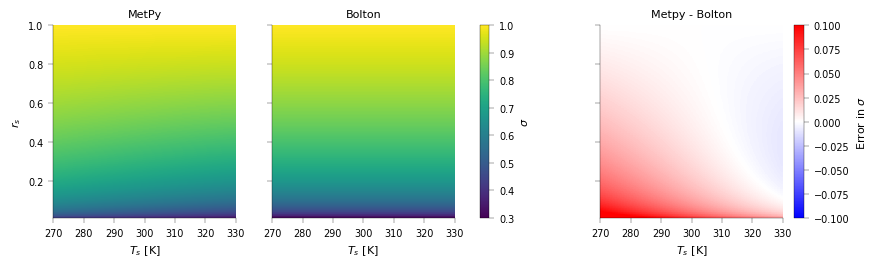

In [5]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)

# Plot sigma_metpy
im0 = ax[0].imshow(sigma_metpy, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='viridis', vmin=0.3, vmax=1)
ax[0].set_title('MetPy')
ax[0].set_xlabel('$T_s$ [K]')
ax[0].set_ylabel('$r_s$')

# Plot sigma_bolton
im1 = ax[1].imshow(sigma_bolton, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='viridis', vmin=0.3, vmax=1)
ax[1].set_title('Bolton')
ax[1].set_xlabel('$T_s$ [K]')
fig.colorbar(im1, ax=ax[:2].ravel(), label='$\sigma$')


# Plot sigma_bolton
im1 = ax[2].imshow(sigma_metpy - sigma_bolton, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='bwr', vmin=-0.1, vmax=0.1)
ax[2].set_title('Metpy - Bolton')
ax[2].set_xlabel('$T_s$ [K]')
fig.colorbar(im1, ax=ax[2:], label='Error in $\sigma$')
plt.show()

### Equality between surface-specific humidity and saturated humidity at the LCL
A quality of a parcel profile is that the specific humidity is held constant below the LCL: $q(p>p_{LCL}) = q_s$; and above the LCL, the humidity is equal to the saturated specific humidity: $q(p<p_{LCL}) = q^*(p<p_{LCL})$.

This requires that at the LCL, we have $q^*(p_{LCL}) = q_s$ along a parcel profile.

With the Bolton approximation of the LCL, we test that equality below.


In [60]:
def get_temp_lcl(temp_surf, rh_surf, temp_surf_lcl_use=None):
    if temp_surf_lcl_use is None:
        temp_surf_lcl_use = temp_surf
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_surf_lcl_use)
    # sigma_lcl = sigma_metpy
    temp_lcl = temp_surf * sigma_lcl ** (R*lapse_dry/g)
    return temp_lcl

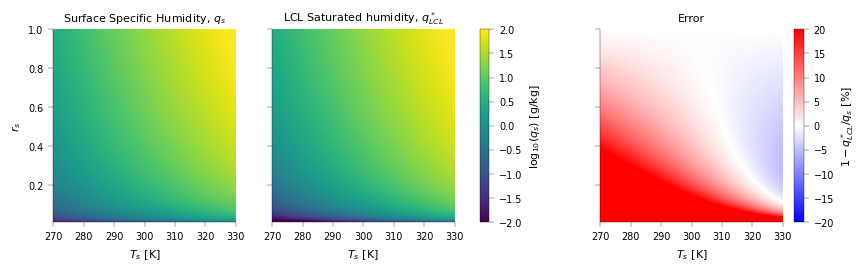

In [61]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)

# Plot sigma_metpy
sphum_surf_use = rh_use * sphum_sat(temp_use, p_surf)*1000
im0 = ax[0].imshow(np.log10(sphum_surf_use), origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='viridis', vmin=-2, vmax=2)
ax[0].set_title('Surface Specific Humidity, $q_s$')
ax[0].set_xlabel('$T_s$ [K]')
ax[0].set_ylabel('$r_s$')
#
# # Plot sigma_bolton
temp_lcl_use = get_temp_lcl(temp_use, rh_use, temp_surf_bolton_use)
sphum_sat_lcl_use = sphum_sat(temp_lcl_use, sigma_bolton * p_surf) * 1000
im1 = ax[1].imshow(np.log10(sphum_sat_lcl_use), origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='viridis', vmin=-2, vmax=2)
ax[1].set_title('LCL Saturated humidity, $q^*_{LCL}$')
ax[1].set_xlabel('$T_s$ [K]')
fig.colorbar(im1, ax=ax[:2].ravel(), label='$\log_{10}(q_s)$ [g/kg]')
#
#
# # Plot sigma_bolton
im1 = ax[2].imshow(100*(sphum_surf_use - sphum_sat_lcl_use) / sphum_surf_use, origin='lower',
                   extent=[temp_use.min(), temp_use.max(), rh_use.min(), rh_use.max()],
                   aspect='auto', cmap='bwr', vmin=-20, vmax=20)
ax[2].set_title('Error')
ax[2].set_xlabel('$T_s$ [K]')
fig.colorbar(im1, ax=ax[2:], label='$1 - q^*_{LCL}/q_s$ [%]')
plt.show()